
# Seatfinder – Auswertung aus PostgreSQL-SQL-Dump (2016–2024)

**Hinweis:** Dieses Notebook benötigt **nur die `.sql`-Dump-Datei** (mit `CREATE TABLE` + `COPY ... FROM stdin;` Blöcken). Es verwendet **keine** Datenbankverbindung – der Dump wird direkt geparst und in `pandas`-DataFrames geladen.

**Was du tun musst:**  
1. Lege deine Dump-Datei (z. B. `seatfinder_dump.sql`) im gleichen Ordner ab, in dem du dieses Notebook startest, oder passe unten den Pfad in `SQL_DUMP_PATH` an.  
2. Führe die Zellen nacheinander aus.


# Data Loading to Data Frames


In [1]:
SQL_DUMP_PATH = "data/seatfinder_tuebingen_2024-10-15.sql" 

import os, io, re, csv, datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Matplotlib Defaults – (keine Styles/keine Farben explizit setzen)
plt.rcParams.update({
    "figure.figsize": (9, 4.5),
    "axes.grid": True
})

assert os.path.exists(SQL_DUMP_PATH), f"SQL_DUMP_PATH nicht gefunden: {SQL_DUMP_PATH}"
print("SQL-Dump gefunden:", SQL_DUMP_PATH)

SQL-Dump gefunden: data/seatfinder_tuebingen_2024-10-15.sql



## Dump-Parser (COPY-Blöcke → DataFrames)

Der Parser liest `COPY schema.table (cols...) FROM stdin;` und sammelt die Tab-getrennten Datenzeilen bis zur Zeile `\.`.  
Leere Werte werden als `NaN` gesetzt, `\N` wird ebenfalls zu `NaN`. Datentypen werden später konvertiert.


In [2]:
import io, re
    
COPY_START_RE = re.compile(r'^COPY\s+([a-zA-Z0-9_\."]+)\s*\((.*?)\)\s+FROM\s+stdin;', re.IGNORECASE)
COPY_END = r'\.'

def parse_sql_dump_to_tables(sql_path):
    tables = {}  # key: full table name (e.g., public.locations) -> dict with keys: columns, rows
    current = None
    cols = []
    rows = []
    with io.open(sql_path, "r", encoding="utf-8", errors="ignore") as f:
        for raw_line in f:
            line = raw_line.rstrip("\n")
            if current is None:
                m = COPY_START_RE.match(line)
                if m:
                    current = m.group(1)  # e.g., public.locations
                    col_str = m.group(2)
                    cols = [c.strip().strip('"') for c in col_str.split(",")]
                    rows = []
            else:
                if line == COPY_END:
                    tables.setdefault(current, {"columns": cols, "rows": []})
                    tables[current]["rows"].extend(rows)
                    current = None
                    cols = []
                    rows = []
                else:
                    parts = line.split("\t")
                    if len(parts) < len(cols):
                        parts += [""] * (len(cols) - len(parts))
                    elif len(parts) > len(cols):
                        parts = parts[:len(cols)]
                    parts = [None if p == r"\N" else p for p in parts]
                    rows.append(parts)
    return tables

tables = parse_sql_dump_to_tables(SQL_DUMP_PATH)
print("Found COPY-Tables:", list(tables.keys()))

Found COPY-Tables: ['public.locations', 'public.manual_counts', 'public.seat_estimates', 'public.wlan_clients']



## DataFrames bauen

Wir ziehen die vier relevanten Tabellen in DataFrames:
- `public.locations`
- `public.seat_estimates`
- `public.wlan_clients`
- `public.manual_counts` (falls vorhanden)


In [3]:
def table_to_df(tables, key):
    t = tables.get(key)
    if not t:
        return None
    df = pd.DataFrame(t["rows"], columns=t["columns"])
    return df

locations = table_to_df(tables, "public.locations")
seat_estimates = table_to_df(tables, "public.seat_estimates")
wlan_clients = table_to_df(tables, "public.wlan_clients")
manual_counts = table_to_df(tables, "public.manual_counts")

for name, df in [("locations", locations), ("seat_estimates", seat_estimates),
                 ("wlan_clients", wlan_clients), ("manual_counts", manual_counts)]:
    if df is None:
        print(f"{name}: not found in Dump")
    else:
        print(f"{name}: {df.shape}")

locations: (20, 14)
seat_estimates: (8323622, 5)
wlan_clients: (17489095, 4)
manual_counts: (1177, 5)



## Typen konvertieren

- `timestamp` → `datetime` (naiv, als Europe/Berlin interpretierbar)
- numerische Spalten → `int/float`


In [4]:
def to_datetime_safe(s):
    return pd.to_datetime(s, errors="coerce")

def to_int_safe(s):
    return pd.to_numeric(s, errors="coerce").astype("Int64")

def to_float_safe(s):
    return pd.to_numeric(s, errors="coerce")

# locations
if locations is not None:
    for c in ["id", "availableseats", "superlocation_id"]:
        if c in locations.columns:
            locations[c] = to_int_safe(locations[c])
    if "timestamp" in locations.columns:
        locations["timestamp"] = to_datetime_safe(locations["timestamp"])

# seat_estimates
if seat_estimates is not None:
    for c in ["id", "location_id", "occupiedseats", "freeseats"]:
        if c in seat_estimates.columns:
            seat_estimates[c] = to_int_safe(seat_estimates[c])
    if "timestamp" in seat_estimates.columns:
        seat_estimates["timestamp"] = to_datetime_safe(seat_estimates["timestamp"])

# wlan_clients
if wlan_clients is not None:
    for c in ["id", "location_id", "numberofclients"]:
        if c in wlan_clients.columns:
            wlan_clients[c] = to_int_safe(wlan_clients[c])
    if "timestamp" in wlan_clients.columns:
        wlan_clients["timestamp"] = to_datetime_safe(wlan_clients["timestamp"])

# manual_counts
if manual_counts is not None:
    for c in ["id", "location_id", "occupiedseats", "freeseats"]:
        if c in manual_counts.columns:
            manual_counts[c] = to_int_safe(manual_counts[c])
    if "timestamp" in manual_counts.columns:
        manual_counts["timestamp"] = to_datetime_safe(manual_counts["timestamp"])

# Nützliche Lookup-Infos
if locations is not None:
    loc_lookup = locations.set_index("id")[["name","longname","availableseats"]]
else:
    loc_lookup = pd.DataFrame()

print("Conversion finished.")

Conversion finished.



## (Optional) CSV-Exporte

Praktisch, wenn man die Aggregationen außerhalb des Notebooks prüfen möchte.


In [ ]:
OUTDIR = "exports"
os.makedirs(OUTDIR, exist_ok=True)

if locations is not None: locations.to_csv(os.path.join(OUTDIR, "locations.csv"), index=False)
if seat_estimates is not None: seat_estimates.to_csv(os.path.join(OUTDIR, "seat_estimates.csv"), index=False)
if wlan_clients is not None: wlan_clients.to_csv(os.path.join(OUTDIR, "wlan_clients.csv"), index=False)
if manual_counts is not None: manual_counts.to_csv(os.path.join(OUTDIR, "manual_counts.csv"), index=False)

print("CSV-Exporte in:", OUTDIR)

# Data Merging and Creating one useful Data Frame

### Keep only columns that are relevant to us:
1. `Locations.csv`: 
    -  removing: name, url, building, level, room, geocoordinates, wlanaccesspoints, ethernetswitches, superlocation_id
    - keeping: id, timestamp, longname, availableseats, weeklyopeninghours

2. `Manual_Counts.csv`:
    - removing: none
    - keeping: id, location_id, occupiedseats, freeseats, timestamp

3. `Estimated_seats.csv`:
    - removing: none
    - keeping: id, location_id, occupiedseats, freeseats, timestamp

4. `Wlan_clients.csv`: 
    - removing: none
    - keeping: id, location_id, numberofclients, timestamp


In [5]:
# print available columns for each data frame
print(locations.columns)
print(manual_counts.columns)
print(seat_estimates.columns)   
print(wlan_clients.columns)
# removing unused columns from locations
locations_cleaned = locations.drop(["name", "url", "building", "level", "room", "geocoordinates", "wlanaccesspoints", "ethernetswitches", "superlocation_id", "weeklyopeninghours"], axis=1)
locations_cleaned.head()

Index(['id', 'timestamp', 'name', 'longname', 'url', 'building', 'level',
       'room', 'geocoordinates', 'availableseats', 'weeklyopeninghours',
       'wlanaccesspoints', 'ethernetswitches', 'superlocation_id'],
      dtype='object')
Index(['id', 'location_id', 'occupiedseats', 'freeseats', 'timestamp'], dtype='object')
Index(['id', 'location_id', 'occupiedseats', 'freeseats', 'timestamp'], dtype='object')
Index(['id', 'location_id', 'numberofclients', 'timestamp'], dtype='object')


,id,timestamp,longname,availableseats
0,19,2016-01-01,"PCB-Bibliothek, UG",54
1,12,2016-01-01,"Ammerbau, Ebene 6, Links",33
2,20,2016-01-01,Lernzentrum Naturwissenschaften,101
3,3,2016-01-01,"Historischer Lesesaal, Bonatzbau, EG",64
4,18,2016-01-01,"PCB-Bibliothek, EG",57


### Creating columns for 5min and 10min time slots

In [6]:
# create 5-minute slots 
manual_counts["t5"] = manual_counts["timestamp"].dt.floor("5min")
seat_estimates["t5"] = seat_estimates["timestamp"].dt.floor("5min")
wlan_clients["t5"] = wlan_clients["timestamp"].dt.floor("5min")

# create 10-minute slots 
manual_counts["t10"] = manual_counts["timestamp"].dt.floor("10min")
seat_estimates["t10"] = seat_estimates["timestamp"].dt.floor("10min")
wlan_clients["t10"] = wlan_clients["timestamp"].dt.floor("10min")

manual_counts.head()


,id,location_id,occupiedseats,freeseats,timestamp,t5,t10
0,1,3,20,48,2016-04-22 13:34:23,2016-04-22 13:30:00,2016-04-22 13:30:00
1,2,4,6,23,2016-04-25 10:03:55,2016-04-25 10:00:00,2016-04-25 10:00:00
2,3,5,26,132,2016-04-25 10:04:11,2016-04-25 10:00:00,2016-04-25 10:00:00
3,4,12,2,31,2016-04-25 10:04:28,2016-04-25 10:00:00,2016-04-25 10:00:00
4,5,13,12,23,2016-04-25 10:04:37,2016-04-25 10:00:00,2016-04-25 10:00:00


In [7]:
seat_estimates.head()

,id,location_id,occupiedseats,freeseats,timestamp,t5,t10
0,1,16,16,15,2016-04-25 10:07:11,2016-04-25 10:05:00,2016-04-25 10:00:00
1,2,15,5,96,2016-04-25 10:07:11,2016-04-25 10:05:00,2016-04-25 10:00:00
2,3,6,12,30,2016-04-25 10:07:11,2016-04-25 10:05:00,2016-04-25 10:00:00
3,4,7,13,14,2016-04-25 10:07:11,2016-04-25 10:05:00,2016-04-25 10:00:00
4,5,8,12,74,2016-04-25 10:07:11,2016-04-25 10:05:00,2016-04-25 10:00:00


In [8]:
wlan_clients.head()

,id,location_id,numberofclients,timestamp,t5,t10
0,5,18,32,2016-04-12 13:01:09,2016-04-12 13:00:00,2016-04-12 13:00:00
1,6,17,37,2016-04-12 13:01:09,2016-04-12 13:00:00,2016-04-12 13:00:00
2,7,19,14,2016-04-12 13:01:09,2016-04-12 13:00:00,2016-04-12 13:00:00
3,8,20,42,2016-04-12 13:01:09,2016-04-12 13:00:00,2016-04-12 13:00:00
4,9,15,15,2016-04-12 13:01:09,2016-04-12 13:00:00,2016-04-12 13:00:00


### Merging data frames to one with all the informations
- grouping each data frame by time and location over 10 minutes
    - aggregation rule: mean
- handeling column colision 
- merging data frames into one 



In [9]:
# aggregation rules for every data frame 

agg_rules_wlan_clients = {         
    "numberofclients": "mean"         
}
agg_rules_manual_counts = {
    "occupiedseats": "mean",
    "freeseats": "mean"  
}
agg_rules_seat_estimates = {
    "occupiedseats": "mean",
    "freeseats": "mean"  
}

# grouping with 10 minutes time slots and location id
wlan_clients_agg = (wlan_clients.groupby(["t10", "location_id"]).agg(agg_rules_wlan_clients).reset_index())
manual_counts_agg = (manual_counts.groupby(["t10", "location_id"]).agg(agg_rules_manual_counts).reset_index())
seat_estimates_agg = (seat_estimates.groupby(["t10", "location_id"]).agg(agg_rules_seat_estimates).reset_index())

In [10]:
# sanity check 
locations_cleaned.head(20)
#manual_counts_agg.head()
#seat_estimates_agg.head()
#wlan_clients_agg.head()

,id,timestamp,longname,availableseats
0,19,2016-01-01,"PCB-Bibliothek, UG",54
1,12,2016-01-01,"Ammerbau, Ebene 6, Links",33
2,20,2016-01-01,Lernzentrum Naturwissenschaften,101
3,3,2016-01-01,"Historischer Lesesaal, Bonatzbau, EG",64
4,18,2016-01-01,"PCB-Bibliothek, EG",57
5,5,2016-01-01,"Ammerbau, Ebene 3, Rechts",158
6,16,2016-01-01,"Alte Waschhalle, hinten",31
7,15,2016-01-01,"Alte Waschhalle, vorne",101
8,7,2016-01-01,"Ammerbau, Ebene 4, Mitte",27
9,8,2016-01-01,"Doktorandenbereich, Ammerbau, Ebene 4, Rechts",86


In [11]:
# renaming columns to prevent column colusion
locations_cleaned.rename(columns={"id": "location_id"}, inplace=True)
manual_counts_agg.rename(columns={"occupiedseats": "manual_count", "freeseats": "freeseats_manual"}, inplace=True)
seat_estimates_agg.rename(columns={"occupiedseats": "estimated_seats"}, inplace=True)

In [12]:
seat_estimates_agg.head()

,t10,location_id,estimated_seats,freeseats
0,2016-04-25 10:00:00,1,89.0,79.0
1,2016-04-25 10:00:00,2,24.0,70.0
2,2016-04-25 10:00:00,6,12.0,30.0
3,2016-04-25 10:00:00,7,13.0,14.0
4,2016-04-25 10:00:00,8,12.0,74.0


In [13]:
# merging data frames by time and location id 
merged = (seat_estimates_agg.merge(manual_counts_agg, on=["t10", "location_id"], how="outer").merge(wlan_clients_agg, on=["t10", "location_id"], how="outer"))

In [14]:
# create lookup with locations data frame
location_lookup = (locations_cleaned[["location_id", "longname", "availableseats"]].drop_duplicates("location_id"))
merged = merged.merge(location_lookup, on="location_id", how="left")


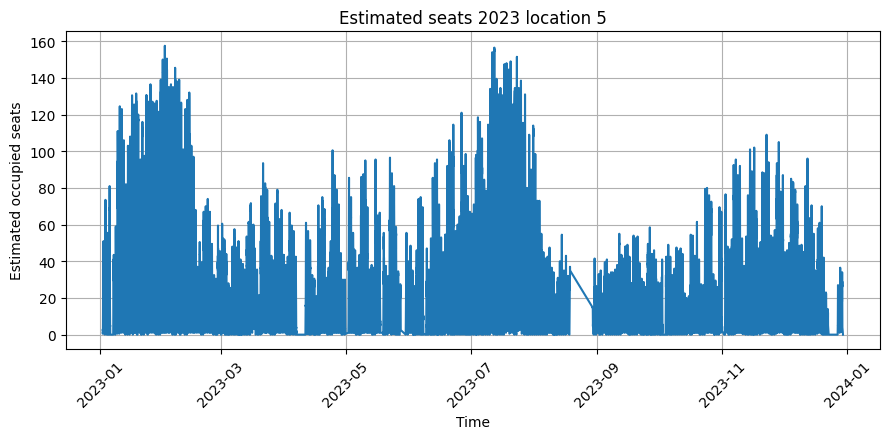

In [15]:
# Quick data sanity plot - seat_estimates over a year 
import matplotlib.pyplot as plt

# choose year and location
year = 2023
location_id = 5

# restrict to 2022 and rows where estimates exist
data_2022 = merged[(merged["t10"].dt.year == year) &(merged["estimated_seats"].notna())]

plot_data = (
    merged[
        (merged["location_id"] == location_id) &
        (merged["t10"].dt.year == year)
    ]
    .dropna(subset=["estimated_seats"])
    .sort_values("t10")
)

plt.figure()
plt.plot(plot_data["t10"], plot_data["estimated_seats"])
plt.xlabel("Time")
plt.ylabel("Estimated occupied seats")
plt.title(f"Estimated seats {year} location {location_id}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Adding Building_id and valley-hill help column for grouping by locations


Each `location_id` is assigned to a `building_id`.  
Locations belonging to the same building share the same `building_id`.

#### Mapping buildings

- **Building 1: Ammerbau**: 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14  
- **Building 2: Waschhalle**: 15, 16  
- **Building 3: PCB**: 18, 19  
- **Building 4: Bonatzbau**: 2, 3  
- **Building 5: Bereichsbibliothek**: 17  
- **Building 6: Lernzentrum Tal**: 1  
- **Building 7: Lernzentrum Morgenstelle**: 20  

#### Mapping Hill or Valley

Each `location_id` is assigned to  `is_hill` or not.  
Locations with flag `1` are located on a hill and all locations with `0` are in the valley.

- Buldings on the hill: 3, 5, 7


In [16]:
# mapping buildings
building_map = {
    4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 
    9: 1, 10: 1, 11: 1, 12: 1, 13: 1,
    14: 1, 15: 2, 16: 2, 18: 3, 19: 3,
    3: 4, 2: 4, 17: 5, 1: 6, 20: 7
}

# create new building_id column 
merged["building_id"] = merged["location_id"].map(building_map)
merged.head()

,t10,location_id,estimated_seats,freeseats,manual_count,freeseats_manual,numberofclients,longname,availableseats,building_id
0,2016-04-12 13:00:00,1,<NA>,<NA>,<NA>,<NA>,49.5,"Lernzentrum, Hauptgebäude, 1. OG",168,6
1,2016-04-12 13:00:00,2,<NA>,<NA>,<NA>,<NA>,40.75,"Bonatzbau, EG",94,4
2,2016-04-12 13:00:00,3,<NA>,<NA>,<NA>,<NA>,32.25,"Historischer Lesesaal, Bonatzbau, EG",64,4
3,2016-04-12 13:00:00,4,<NA>,<NA>,<NA>,<NA>,16.0,"Ammerbau, Ebene 3, Links",29,1
4,2016-04-12 13:00:00,5,<NA>,<NA>,<NA>,<NA>,41.25,"Ammerbau, Ebene 3, Rechts",158,1


In [17]:
# create flag for hill or valley location 
hill_buildings = {3, 5, 7}
merged["is_hill"] = merged["building_id"].isin(hill_buildings).astype(int)
merged.head()

,t10,location_id,estimated_seats,freeseats,manual_count,freeseats_manual,numberofclients,longname,availableseats,building_id,is_hill
0,2016-04-12 13:00:00,1,<NA>,<NA>,<NA>,<NA>,49.5,"Lernzentrum, Hauptgebäude, 1. OG",168,6,0
1,2016-04-12 13:00:00,2,<NA>,<NA>,<NA>,<NA>,40.75,"Bonatzbau, EG",94,4,0
2,2016-04-12 13:00:00,3,<NA>,<NA>,<NA>,<NA>,32.25,"Historischer Lesesaal, Bonatzbau, EG",64,4,0
3,2016-04-12 13:00:00,4,<NA>,<NA>,<NA>,<NA>,16.0,"Ammerbau, Ebene 3, Links",29,1,0
4,2016-04-12 13:00:00,5,<NA>,<NA>,<NA>,<NA>,41.25,"Ammerbau, Ebene 3, Rechts",158,1,0


### adding current opening hours to data frame

In [18]:
openings = pd.read_csv("data/locations.csv")
openings.head()

,id,timestamp,name,longname,url,building,level,room,geocoordinates,availableseats,weeklyopeninghours,wlanaccesspoints,ethernetswitches,superlocation_id,Unnamed: 14,openingWo,closingWo,openingWe,closingWe
0,16,2016-01-01,00:00:00,UBWZB,"Alte Waschhalle, hinten",http://tuebingen.artec-berlin.de/?lang=de_DE&m...,NaN,NaN,NaN,48.52423,9.06268,31.0,"C:23:""Leitsystem\\OpeningHours"":1753:{{""base_t...",/^br21-EG-Hintereingang-[0-9]+$/,NaN,08:00:00,00:00:00,10:00:00,22:00:00
1,15,2016-01-01,00:00:00,UBWZA,"Alte Waschhalle, vorne",http://tuebingen.artec-berlin.de/?lang=de_DE&m...,NaN,NaN,NaN,48.52440,9.06227,101.0,"C:23:""Leitsystem\\OpeningHours"":1753:{{""base_t...",/^br21-EG-Lesesaal3-[0-9]+|br21-OG-Lesesaal1-[...,NaN,08:00:00,00:00:00,10:00:00,22:00:00
2,4,2016-01-01,00:00:00,UBA3A,"Ammerbau, Ebene 3, Links",http://tuebingen.artec-berlin.de/?lang=de_DE&m...,NaN,3,NaN,48.52492,9.06310,29.0,"C:23:""Leitsystem\\OpeningHours"":1753:{{""base_t...",/^br25-3E-links-[0-9]+$/,NaN,08:00:00,00:00:00,10:00:00,22:00:00
3,5,2016-01-01,00:00:00,UBA3C,"Ammerbau, Ebene 3, Rechts",http://tuebingen.artec-berlin.de/?lang=de_DE&m...,NaN,3,NaN,48.52455,9.06278,158.0,"C:23:""Leitsystem\\OpeningHours"":1753:{{""base_t...",/^br25-3E-rechts-[0-9]+|br25-3E-hintenrechts-[...,NaN,08:00:00,00:00:00,10:00:00,22:00:00
4,6,2016-01-01,00:00:00,UBA4A,"Ammerbau, Ebene 4, Links",http://tuebingen.artec-berlin.de/?lang=de_DE&m...,NaN,4,NaN,48.52492,9.06310,42.0,"C:23:""Leitsystem\\OpeningHours"":1753:{{""base_t...",/^br25-4E-links-[0-9]+|br25-4E-hintenlinks-[0-...,NaN,08:00:00,00:00:00,10:00:00,22:00:00


In [19]:
# converting to datetime 
cols = ["openingWo", "closingWo", "openingWe", "closingWe"]
openings[cols] = openings[cols].apply(lambda s: pd.to_datetime(s, format="%H:%M:%S"))

# drop unused columns 
openings = openings[["openingWo", "closingWo", "openingWe", "closingWe", "id"]]

# drop duplicated in id if there are some 
openings = openings.drop_duplicates("id")

# rename column for merging 
openings = openings.rename(columns={"id": "location_id"})

# merging into main data frame 
merged_final = merged.merge(openings, on="location_id", how="left")


In [20]:
merged_final.head()

,t10,location_id,estimated_seats,freeseats,manual_count,freeseats_manual,numberofclients,longname,availableseats,building_id,is_hill,openingWo,closingWo,openingWe,closingWe
0,2016-04-12 13:00:00,1,<NA>,<NA>,<NA>,<NA>,49.5,"Lernzentrum, Hauptgebäude, 1. OG",168,6,0,1900-01-01 08:00:00,1900-01-01 00:00:00,1900-01-01 10:00:00,1900-01-01 22:00:00
1,2016-04-12 13:00:00,2,<NA>,<NA>,<NA>,<NA>,40.75,"Bonatzbau, EG",94,4,0,1900-01-01 08:00:00,1900-01-01 20:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00
2,2016-04-12 13:00:00,3,<NA>,<NA>,<NA>,<NA>,32.25,"Historischer Lesesaal, Bonatzbau, EG",64,4,0,1900-01-01 08:00:00,1900-01-01 20:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00
3,2016-04-12 13:00:00,4,<NA>,<NA>,<NA>,<NA>,16.0,"Ammerbau, Ebene 3, Links",29,1,0,1900-01-01 08:00:00,1900-01-01 00:00:00,1900-01-01 10:00:00,1900-01-01 22:00:00
4,2016-04-12 13:00:00,5,<NA>,<NA>,<NA>,<NA>,41.25,"Ammerbau, Ebene 3, Rechts",158,1,0,1900-01-01 08:00:00,1900-01-01 00:00:00,1900-01-01 10:00:00,1900-01-01 22:00:00


### Save final data frame to CSV
- this data frame then can be use for data Cleaning and Sanity checks 
- it saves the data frame into the `data` folder 
- read data with following code line: `data = pd.read_csv("data/merged_final.csv")`

In [ ]:
# save csv in data folder 
merged_final.to_csv("data/merged_final.csv", index=False)


In [22]:
# check if saving worked 
pd.read_csv("data/merged_final.csv").head()


,t10,location_id,estimated_seats,freeseats,manual_count,freeseats_manual,numberofclients,longname,availableseats,building_id,is_hill,openingWo,closingWo,openingWe,closingWe
0,2016-04-12 13:00:00,1,NaN,NaN,NaN,NaN,49.50,"Lernzentrum, Hauptgebäude, 1. OG",168,6,0,1900-01-01 08:00:00,1900-01-01 00:00:00,1900-01-01 10:00:00,1900-01-01 22:00:00
1,2016-04-12 13:00:00,2,NaN,NaN,NaN,NaN,40.75,"Bonatzbau, EG",94,4,0,1900-01-01 08:00:00,1900-01-01 20:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00
2,2016-04-12 13:00:00,3,NaN,NaN,NaN,NaN,32.25,"Historischer Lesesaal, Bonatzbau, EG",64,4,0,1900-01-01 08:00:00,1900-01-01 20:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00
3,2016-04-12 13:00:00,4,NaN,NaN,NaN,NaN,16.00,"Ammerbau, Ebene 3, Links",29,1,0,1900-01-01 08:00:00,1900-01-01 00:00:00,1900-01-01 10:00:00,1900-01-01 22:00:00
4,2016-04-12 13:00:00,5,NaN,NaN,NaN,NaN,41.25,"Ammerbau, Ebene 3, Rechts",158,1,0,1900-01-01 08:00:00,1900-01-01 00:00:00,1900-01-01 10:00:00,1900-01-01 22:00:00
